In [ ]:
!pip install torch torchvision torchaudio --quiet
!pip install torch-geometric --extra-index-url https://data.pyg.org/whl/torch-2.0.0+cu118.html --quiet
!pip install scikit-learn matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:

import os
import random
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ==============================================
# Step 2: Set Seeds for Reproducibility
# ==============================================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# ==============================================
# Step 3: Load Data
# ==============================================
# Your CSV paths - change if needed
interaction_df = pd.read_csv("/content/drive/MyDrive/Datasets/protein_interactions_CSV.csv", header=None)
interaction_df.columns = ['protein1', 'protein2', 'interaction_score', 'interaction_label']

label_map = {'Weak': 0, 'Moderate': 1, 'Strong': 2}
interaction_df['interaction_label'] = interaction_df['interaction_label'].map(label_map)

features_df = pd.read_csv("/content/drive/MyDrive/Datasets/transposed_data.csv", index_col=0)
features_df.index.name = None

protein_ids = pd.Index(sorted(set(interaction_df['protein1']).union(set(interaction_df['protein2']))))
valid_proteins = protein_ids.intersection(features_df.index)
protein_to_idx = {protein: idx for idx, protein in enumerate(valid_proteins)}

filtered_edges = interaction_df[
    interaction_df['protein1'].isin(valid_proteins) & interaction_df['protein2'].isin(valid_proteins)
]

edge_index, edge_attr, edge_labels = [], [], []
for _, row in filtered_edges.iterrows():
    src = protein_to_idx[row['protein1']]
    dst = protein_to_idx[row['protein2']]
    edge_index.append([src, dst])
    edge_attr.append([row['interaction_score']])
    edge_labels.append(row['interaction_label'])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)
edge_labels = torch.tensor(edge_labels, dtype=torch.long)
features_df = features_df.loc[valid_proteins]
x = torch.tensor(features_df.values, dtype=torch.float)
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=edge_labels)

# ==============================================
# Step 4: Clean Graph
# ==============================================
def graph_validation_report(data):
    edge_index = data.edge_index
    self_loops = (edge_index[0] == edge_index[1])
    num_self_loops = self_loops.sum().item()
    edge_tuples = [tuple(e) for e in edge_index.t().tolist()]
    unique_edges = set(edge_tuples)
    num_duplicates = len(edge_tuples) - len(unique_edges)
    connected_nodes = torch.unique(edge_index)
    all_nodes = torch.arange(data.num_nodes)
    num_isolated = len(set(all_nodes.tolist()) - set(connected_nodes.tolist()))

    print("GRAPH VALIDATION REPORT")
    print(f"Self-loops: {num_self_loops}")
    print(f"Duplicate edges: {num_duplicates}")
    print(f"Isolated nodes: {num_isolated} of {data.num_nodes}")
    print(data)
    return num_self_loops, num_duplicates, num_isolated

def clean_graph_undirected_no_dup(data, label_strategy="first"):
    edge_index, edge_attr, edge_labels = data.edge_index, data.edge_attr, data.y
    mask = edge_index[0] != edge_index[1]
    edge_index = edge_index[:, mask]
    edge_attr = edge_attr[mask]
    edge_labels = edge_labels[mask]
    row, col = edge_index
    min_nodes = torch.min(row, col)
    max_nodes = torch.max(row, col)
    normalized_edges = torch.stack([min_nodes, max_nodes], dim=0)
    combined = torch.cat([normalized_edges.t(),
                          edge_attr,
                          edge_labels.view(-1, 1)], dim=1)
    combined = combined[combined[:, 0].argsort()]
    unique_edges = torch.unique(combined[:, :2], dim=0)
    if label_strategy == "first":
        edge_attr_new = combined[:, 2].view(-1, 1)[:unique_edges.size(0)]
        edge_labels_new = combined[:, 3].view(-1)[:unique_edges.size(0)]
    edge_index_new = unique_edges.t().long()
    data.edge_index = edge_index_new
    data.edge_attr = edge_attr_new
    data.y = edge_labels_new.long()
    return data

print("Before cleaning:")
graph_validation_report(data)
data = clean_graph_undirected_no_dup(data)
print("\nAfter cleaning:")
graph_validation_report(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
data.y = data.y.long().to(device)

labels_np = data.y.cpu().numpy().astype(int)
(unique, counts) = np.unique(labels_np, return_counts=True)
label_counts = dict(zip(unique.tolist(), counts.tolist()))
print("Label distribution:", label_counts)


Before cleaning:
GRAPH VALIDATION REPORT
Self-loops: 0
Duplicate edges: 0
Isolated nodes: 0 of 18696
Data(x=[18696, 1024], edge_index=[2, 1048368], edge_attr=[1048368, 1], y=[1048368])

After cleaning:
GRAPH VALIDATION REPORT
Self-loops: 0
Duplicate edges: 0
Isolated nodes: 0 of 18696
Data(x=[18696, 1024], edge_index=[2, 675122], edge_attr=[675122, 1], y=[675122])
Label distribution: {0: 484804, 1: 112797, 2: 77521}


In [ ]:
# ==============================================
# Step 5: 70-30 Train/Test Split + Weighted Sampler
# ==============================================
num_edges = data.edge_index.size(1)
indices = np.arange(num_edges)
np.random.shuffle(indices)
split_idx = int(0.7 * num_edges)  # 70-30 split
train_idx_np = indices[:split_idx]
test_idx_np = indices[split_idx:]

num_classes = int(max(labels_np) + 1)
class_counts_array = np.zeros(num_classes, dtype=np.int64)
for k, v in label_counts.items():
    class_counts_array[int(k)] = v
class_counts_safe = class_counts_array.copy()
class_counts_safe[class_counts_safe == 0] = 1
weights_per_class = 1.0 / class_counts_safe
samples_weight = np.array([weights_per_class[int(data.y[i].item())] for i in train_idx_np])
samples_weight = samples_weight.astype(np.float64)
sampler = WeightedRandomSampler(torch.DoubleTensor(samples_weight), num_samples=len(samples_weight), replacement=True)

train_dataset = TensorDataset(torch.tensor(train_idx_np, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=512, sampler=sampler)
test_idx = torch.tensor(test_idx_np, dtype=torch.long, device=device)

# ==============================================
# Step 6: Model & Loss
# ==============================================
class EdgeGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels=256, num_classes=3, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = dropout
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden_channels * 2 + 1, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, num_classes)
        )

    def encode_nodes(self, x, edge_index):
        h = F.relu(self.conv1(x, edge_index))
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = F.relu(self.conv2(h, edge_index))
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = F.relu(self.conv3(h, edge_index))
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = F.relu(self.conv4(h, edge_index))
        h = F.dropout(h, p=self.dropout, training=self.training)
        return h

    def classify_edges_from_node_emb(self, node_emb, edge_pairs, edge_attr):
        src = edge_pairs[:, 0]
        dst = edge_pairs[:, 1]
        h_u = node_emb[src]
        h_v = node_emb[dst]
        edge_repr = torch.cat([h_u, h_v, edge_attr], dim=1)
        return self.edge_mlp(edge_repr)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        logp = F.log_softmax(inputs, dim=1)
        p = torch.exp(logp)
        pt = p[torch.arange(len(targets), device=inputs.device), targets]
        at = 1.0 if self.alpha is None else self.alpha[targets]
        loss = - at * ((1 - pt) ** self.gamma) * logp[torch.arange(len(targets), device=inputs.device), targets]
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# ==============================================
# Step 7: Training Function (Tracks Curves)
# ==============================================
def train_model(model, loss_fn, epochs=20, lr=1e-3, wd=5e-4):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    train_losses, test_accs, test_f1_macros = [], [], []
    logits_test_final = None
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for batch in train_loader:
            batch_edges = batch[0].to(device)
            optimizer.zero_grad()
            node_emb = model.encode_nodes(data.x, data.edge_index)
            edge_pairs = data.edge_index.t()[batch_edges]
            edge_attr_batch = data.edge_attr[batch_edges]
            logits = model.classify_edges_from_node_emb(node_emb, edge_pairs, edge_attr_batch)
            labels_batch = data.y[batch_edges]
            loss = loss_fn(logits, labels_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            del node_emb, edge_pairs, edge_attr_batch, logits, labels_batch
            torch.cuda.empty_cache()
            gc.collect()
        model.eval()
        with torch.no_grad():
            node_emb_eval = model.encode_nodes(data.x, data.edge_index)
            edge_pairs_test = data.edge_index.t()[test_idx]
            edge_attr_test = data.edge_attr[test_idx]
            logits_test = model.classify_edges_from_node_emb(node_emb_eval, edge_pairs_test, edge_attr_test)
            preds_test = logits_test.argmax(dim=1).cpu().numpy()
            y_test_eval = data.y[test_idx].cpu().numpy()
            test_acc = (preds_test == y_test_eval).mean()
            test_f1_macro = f1_score(y_test_eval, preds_test, average='macro', zero_division=0)
        train_losses.append(epoch_loss / len(train_loader))
        test_accs.append(test_acc)
        test_f1_macros.append(test_f1_macro)
        logits_test_final = logits_test
        print(f"[{model.__class__.__name__}] Epoch {epoch:03d} | Loss: {train_losses[-1]:.4f} | Acc: {test_acc:.4f} | F1-macro: {test_f1_macro:.4f}")
    return model, logits_test_final, train_losses, test_accs, test_f1_macros

# ==============================================
# Step 8: Train Ensemble
# ==============================================
in_channels = data.x.size(1)
hidden = 256
class_counts_list = np.array([label_counts.get(i, 0) for i in range(num_classes)], dtype=np.float32)
class_counts_list[class_counts_list == 0] = 1.0
inv_freq = 1.0 / class_counts_list
weights_tensor = torch.tensor(inv_freq / inv_freq.sum() * num_classes, dtype=torch.float, device=device)

model1 = EdgeGCN(in_channels, hidden, num_classes)
loss1 = nn.CrossEntropyLoss(weight=weights_tensor)
model1, logits1, loss_curve1, acc_curve1, f1_curve1 = train_model(model1, loss1)

alpha_for_focal = weights_tensor.clone().detach()
model2 = EdgeGCN(in_channels, hidden, num_classes)
loss2 = FocalLoss(alpha=alpha_for_focal, gamma=2.0)
model2, logits2, loss_curve2, acc_curve2, f1_curve2 = train_model(model2, loss2)

# ==============================================
# Step 9: Ensemble & Metrics
# ==============================================
avg_logits = (logits1 + logits2) / 2.0
preds = avg_logits.argmax(dim=1).cpu().numpy()
y_test = data.y[test_idx].cpu().numpy()
# ==============================================
# Step 10: Save Models and Results
# ==============================================

import os

save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save the trained models' state dicts
torch.save(model1.state_dict(), os.path.join(save_dir, "edgegcn_model1_crossentropy.pth"))
torch.save(model2.state_dict(), os.path.join(save_dir, "edgegcn_model2_focalloss.pth"))

# Optionally save training curves and metrics for analysis
np.save(os.path.join(save_dir, "loss_curve_model1.npy"), np.array(loss_curve1))
np.save(os.path.join(save_dir, "acc_curve_model1.npy"), np.array(acc_curve1))
np.save(os.path.join(save_dir, "f1_curve_model1.npy"), np.array(f1_curve1))

np.save(os.path.join(save_dir, "loss_curve_model2.npy"), np.array(loss_curve2))
np.save(os.path.join(save_dir, "acc_curve_model2.npy"), np.array(acc_curve2))
np.save(os.path.join(save_dir, "f1_curve_model2.npy"), np.array(f1_curve2))

# Save the test predictions and labels
np.save(os.path.join(save_dir, "ensemble_preds.npy"), preds)
np.save(os.path.join(save_dir, "y_test.npy"), y_test)

print(f"✅ Models and results saved in: {save_dir}")


[EdgeGCN] Epoch 001 | Loss: 0.2635 | Acc: 0.9545 | F1-macro: 0.9421
[EdgeGCN] Epoch 002 | Loss: 0.0725 | Acc: 0.9685 | F1-macro: 0.9539
[EdgeGCN] Epoch 003 | Loss: 0.0692 | Acc: 0.9528 | F1-macro: 0.9365
[EdgeGCN] Epoch 004 | Loss: 0.0680 | Acc: 0.9503 | F1-macro: 0.9379
[EdgeGCN] Epoch 005 | Loss: 0.0705 | Acc: 0.9860 | F1-macro: 0.9803
[EdgeGCN] Epoch 006 | Loss: 0.0680 | Acc: 0.9839 | F1-macro: 0.9806
[EdgeGCN] Epoch 007 | Loss: 0.0691 | Acc: 0.9262 | F1-macro: 0.8926
[EdgeGCN] Epoch 008 | Loss: 0.0741 | Acc: 0.9763 | F1-macro: 0.9680
[EdgeGCN] Epoch 009 | Loss: 0.0705 | Acc: 0.9824 | F1-macro: 0.9759
[EdgeGCN] Epoch 010 | Loss: 0.0683 | Acc: 0.9711 | F1-macro: 0.9652
[EdgeGCN] Epoch 011 | Loss: 0.0693 | Acc: 0.9797 | F1-macro: 0.9665
[EdgeGCN] Epoch 012 | Loss: 0.0698 | Acc: 0.9756 | F1-macro: 0.9664
[EdgeGCN] Epoch 013 | Loss: 0.0674 | Acc: 0.9643 | F1-macro: 0.9550
[EdgeGCN] Epoch 014 | Loss: 0.0667 | Acc: 0.9663 | F1-macro: 0.9537
[EdgeGCN] Epoch 015 | Loss: 0.0671 | Acc: 0.9646


Final Classification Report (Ensemble):
              precision    recall  f1-score   support

           0     1.0000    0.9714    0.9855    145133
           1     0.8895    0.9819    0.9334     33964
           2     0.9744    1.0000    0.9871     23440

    accuracy                         0.9765    202537
   macro avg     0.9546    0.9844    0.9687    202537
weighted avg     0.9785    0.9765    0.9770    202537



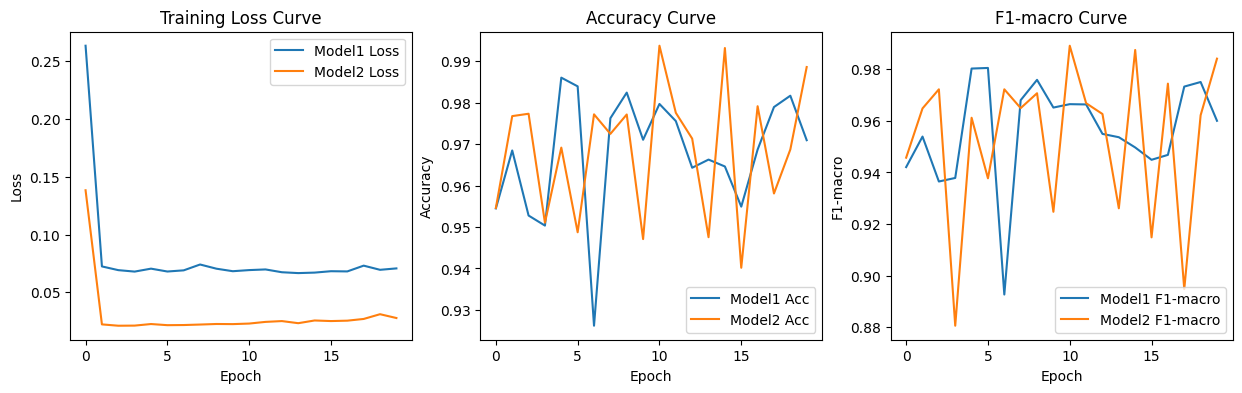

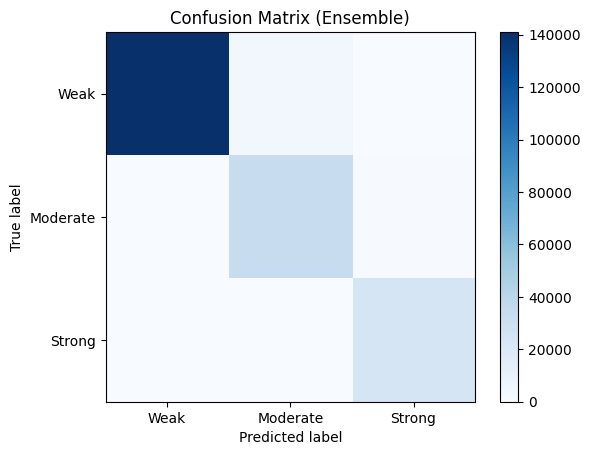

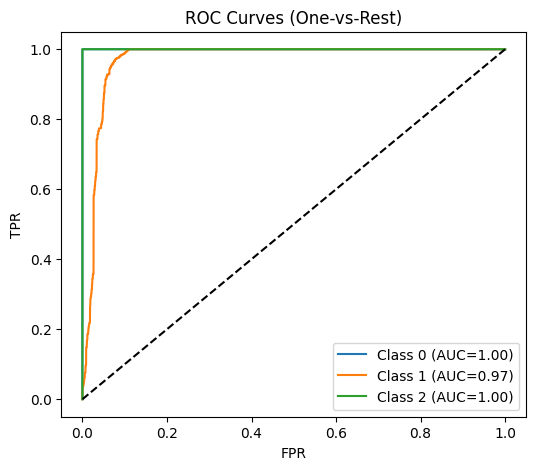

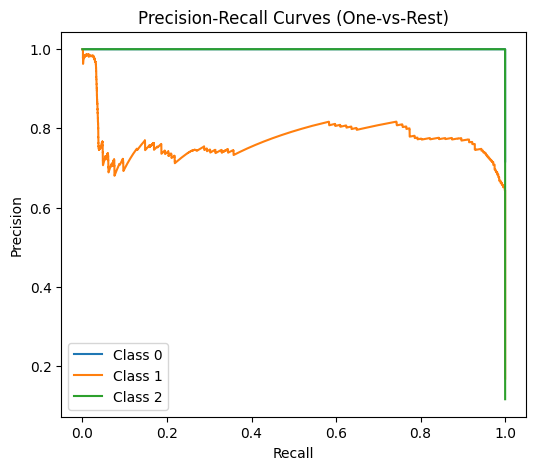

In [ ]:
print("\nFinal Classification Report (Ensemble):")
print(classification_report(y_test, preds, zero_division=0, digits=4))

# ==============================================
# Step 10: Plot Curves
# ==============================================
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(loss_curve1, label="Model1 Loss")
plt.plot(loss_curve2, label="Model2 Loss")
plt.title("Training Loss Curve"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.subplot(1,3,2)
plt.plot(acc_curve1, label="Model1 Acc")
plt.plot(acc_curve2, label="Model2 Acc")
plt.title("Accuracy Curve"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
plt.subplot(1,3,3)
plt.plot(f1_curve1, label="Model1 F1-macro")
plt.plot(f1_curve2, label="Model2 F1-macro")
plt.title("F1-macro Curve"); plt.xlabel("Epoch"); plt.ylabel("F1-macro"); plt.legend()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, preds)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Ensemble)")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, list(label_map.keys()))
plt.yticks(tick_marks, list(label_map.keys()))
plt.ylabel('True label'); plt.xlabel('Predicted label')
plt.show()

# ROC curves
y_test_bin = label_binarize(y_test, classes=list(range(num_classes)))
avg_logits_np = avg_logits.cpu().numpy()
plt.figure(figsize=(6,5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], avg_logits_np[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves (One-vs-Rest)"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.show()

# Precision-Recall curves
plt.figure(figsize=(6,5))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], avg_logits_np[:, i])
    plt.plot(recall, precision, label=f'Class {i}')
plt.title("Precision-Recall Curves (One-vs-Rest)")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.show()
